## CS156 Assignment Week7
 Qiqi Xu
 
 Minerva Schools at KGI

### Yosemite Village yearly weather

Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.
Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error,r2_score
import timeit



years = range(2011, 2016)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8, 9]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

# Convert date into ordinal numbers
for n in range(len(data[:,0])):
    i = data[:,0][n]
    i = str(i)
    i = dt.strptime(i,'%Y%m%d.0').date()
    i = i.strftime('%j')
    data[:,0][n] = i
#data[:,0] = [dt.strptime(i.astype('str'),'%Y%m%d.0').date() for i in data[:,0]]


# Map from HHmm to an integer
data[:, 1] = np.floor_divide(data[:, 1], 100) * 60 + np.mod(data[:, 1], 100)
valid = data[:, 2] > -1000

date = data[valid,0].reshape(-1, 1)
time = data[valid,1].reshape(-1, 1)
temp = data[valid,2]
rain = data[:,3]


In [10]:
#use rbf to turn date and time into richer representation
#Experiment with different numbers of rbf and different widths of the rbf in different dimensions

datetime = np.column_stack((date,time))
train_x, test_x, train_y, test_y = train_test_split(datetime, temp, test_size=0.4, random_state = 123456)

#find evenly spaced-out centers that cover the data range
centers_t = np.linspace(0, 365, 6).reshape(-1, 1)
centers_d = np.linspace(0, 1435, 6).reshape(-1, 1)
sigma_t = 10000.0 #widths
sigma_d = 16000.0 #widths

# New representations:
x_t = rbf_kernel(train_x[:,0].reshape(-1, 1), centers_t, gamma=1/sigma_t)
x_d = rbf_kernel(train_x[:,1].reshape(-1, 1), centers_d, gamma=1/sigma_d)
x_train = np.hstack((x_t,x_d))

start1 = timeit.default_timer()
# Fit into a linear parameter model
regr = linear_model.LinearRegression()
regr.fit(x_train, train_y)

end1 = timeit.default_timer() - start1
print end1

# Use RBF again to convert test data into aforementioned representations
x_t_test = rbf_kernel(test_x[:,0].reshape(-1, 1), centers_t, gamma=1/sigma_t)
x_d_test = rbf_kernel(test_x[:,1].reshape(-1, 1), centers_d, gamma=1/sigma_d)
x_test = np.hstack((x_t_test,x_d_test))

x_predict = x_test
y_predict = regr.predict(x_predict)

0.186607122421


#### 1. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.

Contribution of day-of-the-year defined by R^2 score: 0.64055917934


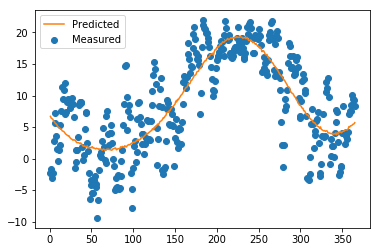

In [189]:
%matplotlib inline
day_index = sorted(list(set(test_x[:,0])))
avg_y_by_day = []
avg_y_by_day_predict = []

for i in day_index:
    avg = np.mean(test_y[test_x[:,0] == i])
    avg_predict = np.mean(y_predict[test_x[:,0] == i])
    avg_y_by_day.append(avg)
    avg_y_by_day_predict.append(avg_predict)

print "Contribution of day-of-the-year defined by R^2 score:",r2_score(avg_y_by_day,avg_y_by_day_predict)    
plt.scatter(day_index, avg_y_by_day, label = 'Measured')
plt.plot(day_index, avg_y_by_day_predict, label ='Predicted',color = 'C1')
plt.legend(loc='best')


Contribution of time-of-the-day defined by R^2 score: 0.876958818054


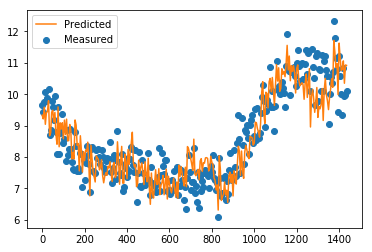

In [188]:
time_index = sorted(list(set(test_x[:,1])))
avg_y_by_time = []
avg_y_by_time_predicted = []

for p in time_index:
    avg = np.mean(test_y[test_x[:,1] == p])
    avg_predicted = np.mean(y_predict[test_x[:,1] == p])
    avg_y_by_time.append(avg)
    avg_y_by_time_predicted.append(avg_predicted)
    
print "Contribution of time-of-the-day defined by R^2 score:",r2_score(avg_y_by_time,avg_y_by_time_predicted)    
plt.scatter(time_index, avg_y_by_time,label = 'Measured')
plt.plot(time_index,avg_y_by_time_predicted,label="Predicted",color = 'C1')
plt.legend(loc='best')


#### 2. Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!

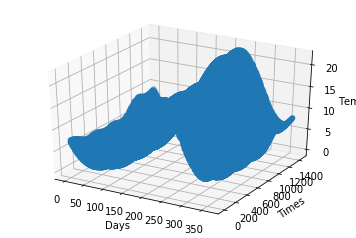

'\navg_temp = []\nfor i in range(365):\n    for j in range(1440):\n        avg = np.mean(test_y[test_x[:,0]==i & test_x[:,1]==j])\n        avg_temp.append(avg)\nprint avg_temp'

In [165]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = test_x[:,0]
ys = test_x[:,1]
zs = y_predict
ax.scatter(xs, ys, zs)
ax.set_xlabel('Days')
ax.set_ylabel('Times')
ax.set_zlabel('Temp')

plt.show()

#### 3. Using mean squared error, quantify how your model performs on the testing data if you:
    - Train with just the daily component of the model
    - Train with just the yearly component of the model
    - Train with the full model.

In [183]:
regr_t = linear_model.LinearRegression()
regr_t.fit(x_t,train_y)
yt_predict = regr_t.predict(x_t_test)
print "Mean squared error trained with only daily informaiton:", mean_squared_error(test_y,yt_predict)

regr_d = linear_model.LinearRegression()
regr_d.fit(x_d,train_y)
yd_predict = regr_d.predict(x_d_test)
print "Mean squared error trained with only yearly informaiton:", mean_squared_error(test_y,yd_predict)

print "Mean squared error trained with full modle", mean_squared_error(test_y,y_predict)

Mean squared error trained with only daily informaiton: 24.4482204738
Mean squared error trained with only yearly informaiton: 59.7434092161
Mean squared error trained with full modle 22.8047817659


### Yosemite Village rain

1. Using logistic regression predict the probability of rain in a given day of the year.
2. What accuracy would a classifier get if it simply predicted “No rain” all the time?

             precision    recall  f1-score   support

          0       0.81      1.00      0.89        88
          1       0.00      0.00      0.00        21

avg / total       0.65      0.81      0.72       109

Mean accuracy on test data: 0.807339449541


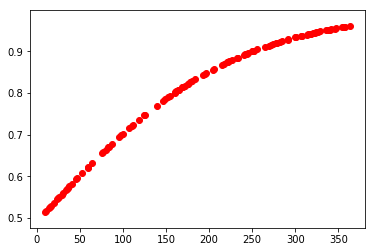

---------------------
If it simply predicted “No rain” all the time, the accuracy is:  0.807339449541


In [194]:
raindata = data[:,[0,3]]
raindf = pd.DataFrame(data = raindata, columns = ["Date","Rain"])
raindf = raindf[raindf['Rain'] > -1]  
raindf = raindf.groupby('Date', as_index=False).sum()

days = raindf[['Date']]
labels = [1 if label > 0 else 0 for label in raindf['Rain']]


####1
train_x, test_x, train_y, test_y = train_test_split(days, labels, test_size=0.3, random_state = 123)
logreg = LogisticRegression()
logreg.fit(train_x,train_y)
predictions_test = logreg.predict(test_x)
predict_probs = logreg.predict_proba(test_x)
print metrics.classification_report(test_y,predictions_test)
print "Mean accuracy on test data:", logreg.score(test_x,test_y)

#obtain the probablities of class "1"
rain_probs = predict_probs[:,1].reshape(-1,1)
plt.scatter(test_x, rain_probs, label='Rain Probablity Prediction', color='r')
plt.show()

In [195]:
####2
n = test_y.count(1)
accuracy = (len(test_y)-n)/float(len(test_y))
print "---------------------"
print "If it simply predicted “No rain” all the time, the accuracy is: ", accuracy

##Because there are so many days without rain anyways, 
##this model seems to be performing well in regrads to precision of predicing "no rain.

---------------------
If it simply predicted “No rain” all the time, the accuracy is:  0.807339449541


#### 3. Describe your model and data preparation to a level of detail so that another machine learning researcher could reproduce your results.

As there are multiple rainfall information everyday, we first need to define what marks there is rain (when precipitation is larger than 0, disregarding faulty negative measurements ), and consolidate all the rain data of time-of-the-day into one day. 

Afterwards, we label the rain data into a binary list, and then we produce the training and test data sets using days as independent predictors. 

Fit the training set into a logistic regression model and make predictions of the test set. Logistic regression can also produce the probabilities of each class, so here we call logreg.predict_proba to gather that information as well. 